In [1]:
# =========================================
# 1️⃣ IMPORTS
# =========================================
import os
import cv2
import numpy as np
import pandas as pd
from skimage import img_as_float
from skimage.filters import sobel
from scipy.stats import skew, kurtosis, entropy
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import seaborn as sns

# TensorFlow / Keras
from tensorflow.keras import layers, models
from tensorflow import keras

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# XGBoost
from xgboost import XGBClassifier

# PyWavelets
import pywt

In [2]:

# =========================================
# 2️⃣ DATASET PATH
# =========================================
DATASET_PATH = r"C:\Users\Sona\Downloads\official_document"

In [3]:
# =========================================
# 3️⃣ FEATURE EXTRACTION FUNCTIONS
# =========================================
def load_gray(img_path, size=(512,512)):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)/255.0
    img = img_as_float(img)
    return cv2.resize(img, size, interpolation=cv2.INTER_AREA)

def extract_features(img, file_path, class_label):
    file_size_kb = os.path.getsize(file_path)/1024
    pixels = img.flatten()
    mean_intensity = np.mean(pixels)
    std_intensity = np.std(pixels)
    skewness = skew(pixels)
    kurt = kurtosis(pixels)
    ent = entropy(np.histogram(pixels, bins=256, range=(0,1))[0]+1e-6)
    edges = sobel(img)
    edge_density = np.mean(edges>0.1)
    return {
        "file_name": os.path.basename(file_path),
        "class_label": class_label,
        "file_size_kb": file_size_kb,
        "mean_intensity": mean_intensity,
        "std_intensity": std_intensity,
        "skewness": skewness,
        "kurtosis": kurt,
        "entropy": ent,
        "edge_density": edge_density
    }

def process_dataset(root_folder):
    rows=[]
    for scanner_folder in sorted(os.listdir(root_folder)):
        scanner_path = os.path.join(root_folder, scanner_folder)
        if not os.path.isdir(scanner_path):
            continue

        dpi_subfolders = [d for d in os.listdir(scanner_path) if os.path.isdir(os.path.join(scanner_path,d))]

        if dpi_subfolders:
            for dpi in dpi_subfolders:
                dpi_path = os.path.join(scanner_path, dpi)
                tif_files = [f for f in os.listdir(dpi_path) if f.lower().endswith(".tif")]
                for f in tqdm(tif_files, desc=f"{scanner_folder}/{dpi}"):
                    fpath = os.path.join(dpi_path, f)
                    img = load_gray(fpath)
                    row = extract_features(img, fpath, scanner_folder)
                    rows.append(row)
        else:
            tif_files = [f for f in os.listdir(scanner_path) if f.lower().endswith(".tif")]
            for f in tqdm(tif_files, desc=f"{scanner_folder}"):
                fpath = os.path.join(scanner_path, f)
                img = load_gray(fpath)
                row = extract_features(img, fpath, scanner_folder)
                rows.append(row)
    return rows

In [5]:
# =========================================
# 4️⃣ PROCESS DATASET
# =========================================
# ✅ Run this first
all_rows = process_dataset(DATASET_PATH)
df = pd.DataFrame(all_rows)
df.to_csv("image_metadata.csv", index=False)

HP/300: 100%|██████████| 100/100 [00:24<00:00,  4.10it/s]


In [6]:
# =========================================
# 5️⃣ PREPARE FEATURES AND LABELS
# =========================================
# ✅ Run this after dataset is processed
df = df.drop(columns=['file_name'])
y = df['class_label']
X = df.drop(columns=['class_label'])

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [7]:
# =========================================
# 6️⃣ STATISTICAL ML MODELS
# =========================================
# ✅ Run this after preparing features
# Random Forest
rf = RandomForestClassifier(n_estimators=300, class_weight="balanced", random_state=42)
rf.fit(X_train, y_train)

# XGBoost
xgb = XGBClassifier(
    n_estimators=500, learning_rate=0.05, max_depth=8,
    subsample=0.8, colsample_bytree=0.8, objective="multi:softmax",
    num_class=len(le.classes_)
)
xgb.fit(X_train, y_train)

# SVM
svm_model = Pipeline([
    ("s", StandardScaler()),
    ("svc", SVC(kernel="rbf", probability=True, class_weight="balanced"))
])
svm_model.fit(X_train, y_train)

,steps,"[('s', ...), ('svc', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'



==================== Random Forest ====================
Accuracy: 0.3318

              precision    recall  f1-score   support

  Canon120-1       0.04      0.05      0.04        40
  Canon120-2       0.03      0.03      0.03        40
    Canon220       0.38      0.25      0.30        40
 Canon9000-1       0.08      0.07      0.08        40
 Canon9000-2       0.20      0.20      0.20        40
 EpsonV370-1       0.40      0.42      0.41        40
 EpsonV370-2       0.38      0.35      0.36        40
  EpsonV39-1       0.17      0.17      0.17        40
  EpsonV39-2       0.13      0.12      0.13        40
   EpsonV550       0.85      0.97      0.91        40
          HP       1.00      1.00      1.00        40

    accuracy                           0.33       440
   macro avg       0.33      0.33      0.33       440
weighted avg       0.33      0.33      0.33       440



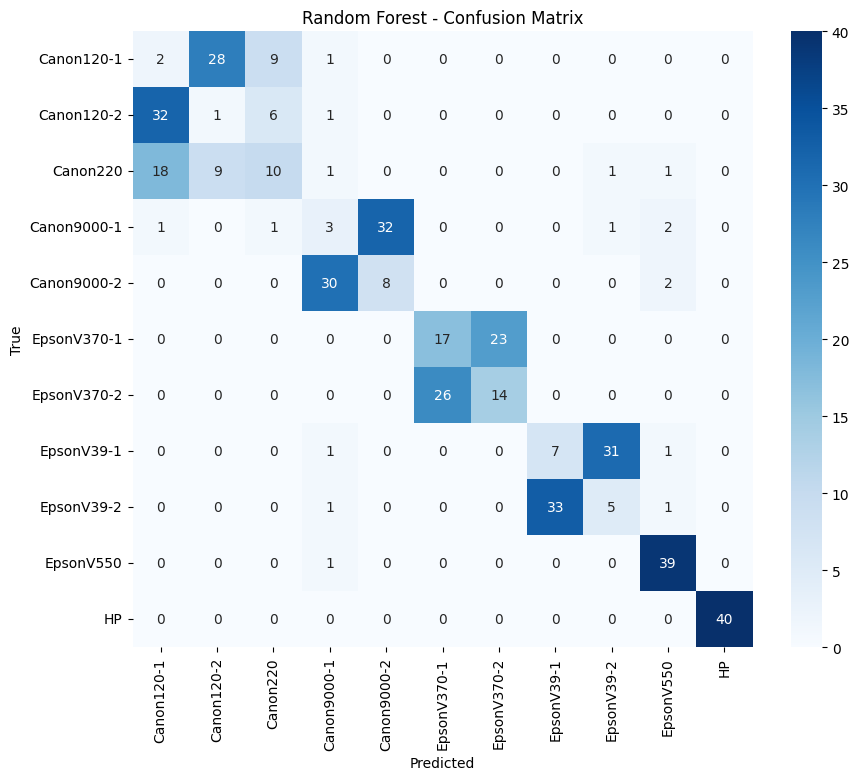


==================== XGBoost ====================
Accuracy: 0.3841

              precision    recall  f1-score   support

  Canon120-1       0.07      0.07      0.07        40
  Canon120-2       0.07      0.07      0.07        40
    Canon220       0.45      0.33      0.38        40
 Canon9000-1       0.29      0.30      0.29        40
 Canon9000-2       0.26      0.25      0.26        40
 EpsonV370-1       0.30      0.25      0.27        40
 EpsonV370-2       0.37      0.42      0.40        40
  EpsonV39-1       0.27      0.28      0.27        40
  EpsonV39-2       0.25      0.25      0.25        40
   EpsonV550       1.00      1.00      1.00        40
          HP       1.00      1.00      1.00        40

    accuracy                           0.38       440
   macro avg       0.39      0.38      0.39       440
weighted avg       0.39      0.38      0.39       440



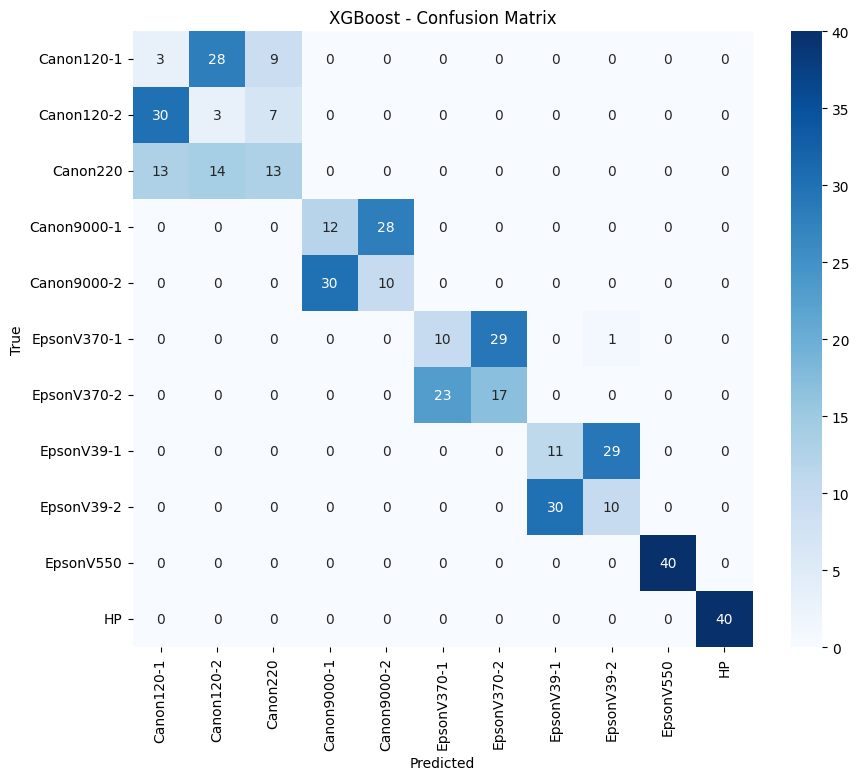


==================== SVM ====================
Accuracy: 0.2795

              precision    recall  f1-score   support

  Canon120-1       0.05      0.03      0.03        40
  Canon120-2       0.08      0.10      0.09        40
    Canon220       0.11      0.17      0.14        40
 Canon9000-1       0.00      0.00      0.00        40
 Canon9000-2       0.09      0.15      0.11        40
 EpsonV370-1       0.50      0.42      0.46        40
 EpsonV370-2       0.39      0.45      0.42        40
  EpsonV39-1       0.10      0.07      0.09        40
  EpsonV39-2       0.33      0.05      0.09        40
   EpsonV550       0.48      0.62      0.54        40
          HP       0.95      1.00      0.98        40

    accuracy                           0.28       440
   macro avg       0.28      0.28      0.27       440
weighted avg       0.28      0.28      0.27       440



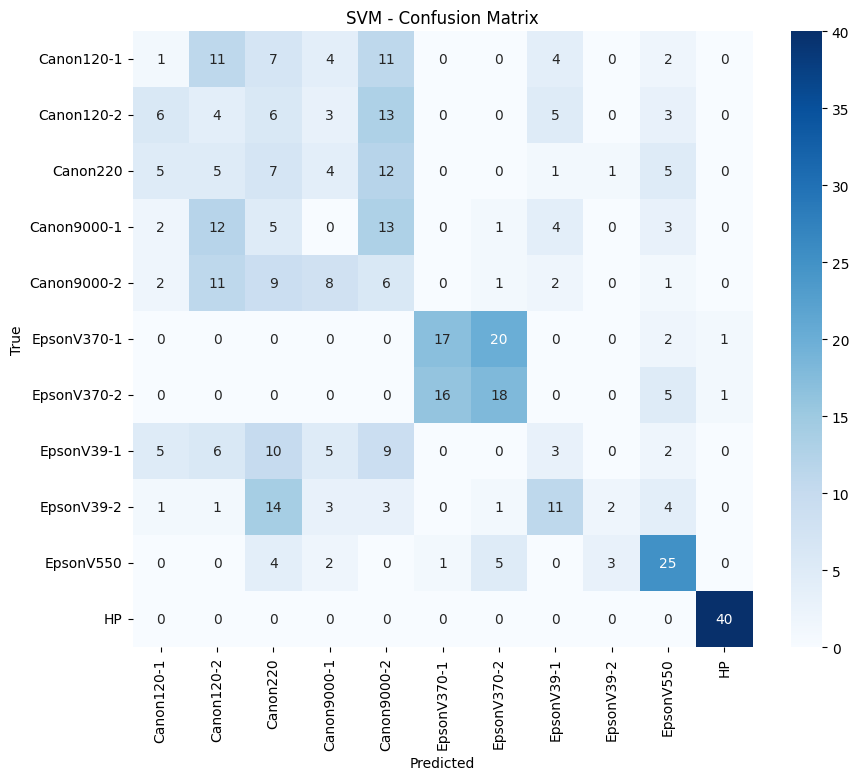

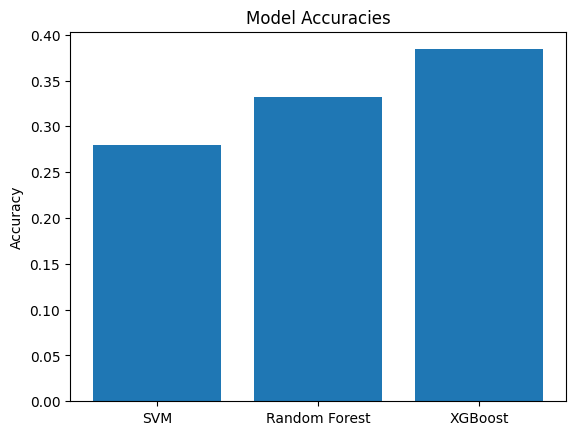

In [8]:
# =========================================
# 7️⃣ MODEL EVALUATION FUNCTION
# =========================================
# ✅ Run this after training models
def evaluate_model(name, model, X_test, y_test):
    print(f"\n==================== {name} ====================")
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print(f"Accuracy: {acc:.4f}\n")
    print(classification_report(y_test, preds, target_names=le.classes_))
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    return acc

rf_acc = evaluate_model("Random Forest", rf, X_test, y_test)
xgb_acc = evaluate_model("XGBoost", xgb, X_test, y_test)
svm_acc = evaluate_model("SVM", svm_model, X_test, y_test)

plt.bar(["SVM", "Random Forest", "XGBoost"], [svm_acc, rf_acc, xgb_acc])
plt.ylabel("Accuracy")
plt.title("Model Accuracies")
plt.show()

In [9]:
# =========================================
# 8️⃣ SAVE MODELS (Optional)
# =========================================
with open("xgb_model.pkl", "wb") as f:
    pickle.dump(xgb, f)
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

In [10]:
# =========================================
# 9️⃣ SINGLE IMAGE PREDICTION (Statistical ML)
# =========================================
# ✅ Run this only **after training the models**
def extract_features_single_image(img_path):
    img = load_gray(img_path)
    file_size_kb = os.path.getsize(img_path)/1024
    pixels = img.flatten()
    mean_intensity = np.mean(pixels)
    std_intensity = np.std(pixels)
    skewness = skew(pixels)
    kurt = kurtosis(pixels)
    ent = entropy(np.histogram(pixels, bins=256, range=(0,1))[0]+1e-6)
    edge_density = np.mean(sobel(img)>0.1)
    feat = [file_size_kb, mean_intensity, std_intensity, skewness, kurt, ent, edge_density]
    return np.array(feat).reshape(1,-1)

sample_img = r"C:\Users\Sona\Downloads\official_document\HP\150\s11_1.tif"
feat = extract_features_single_image(sample_img)
probs = xgb.predict_proba(feat)[0]
pred_idx = np.argmax(probs)
pred_label = le.inverse_transform([pred_idx])[0]
confidence = probs[pred_idx]

print("Predicted Scanner:", pred_label)
print("Confidence:", confidence)

Predicted Scanner: HP
Confidence: 0.99842334


In [11]:
def predict_single_image(img_path, model, label_encoder):
    # Load and preprocess image
    img = load_gray(img_path, size=(256,256))  # adjust size to your CNN
    img = img.reshape(1, 256, 256, 1)  # add batch & channel dims
    
    # Predict
    probs = model.predict(img)[0]
    idx = np.argmax(probs)
    label = label_encoder.inverse_transform([idx])[0]
    confidence = probs[idx]
    return label, confidence


In [16]:
cnn_model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


NameError: name 'cnn_model' is not defined

In [12]:
import cv2
import numpy as np
from skimage import img_as_float
from skimage.filters import sobel
from scipy.stats import skew, kurtosis, entropy

def predict_scanner_single_image(img_path, cnn_model, xgb_model, label_encoder, cnn_size=(256,256)):
    # --- 1️⃣ Extract features for XGBoost ---
    img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img_gray, cnn_size, interpolation=cv2.INTER_AREA)
    img_resized_float = img_as_float(img_gray)
    pixels = img_resized_float.flatten()
    
    file_size_kb = os.path.getsize(img_path)/1024
    mean_intensity = np.mean(pixels)
    std_intensity = np.std(pixels)
    skewness = skew(pixels)
    kurt_value = kurtosis(pixels)
    ent = entropy(np.histogram(pixels, bins=256, range=(0,1))[0]+1e-6)
    edge_density = np.mean(sobel(img_resized_float)>0.1)
    
    xgb_feat = np.array([file_size_kb, mean_intensity, std_intensity, skewness, kurt_value, ent, edge_density]).reshape(1,-1)
    
    xgb_probs = xgb_model.predict_proba(xgb_feat)[0]
    xgb_idx = np.argmax(xgb_probs)
    xgb_label = label_encoder.inverse_transform([xgb_idx])[0]
    xgb_conf = xgb_probs[xgb_idx]
    
    # --- 2️⃣ Preprocess image for CNN ---
    img_cnn = img_resized.astype(np.float32)/255.0
    img_cnn = img_cnn.reshape(1, cnn_size[0], cnn_size[1], 1)
    
    cnn_probs = cnn_model.predict(img_cnn)[0]
    cnn_idx = np.argmax(cnn_probs)
    cnn_label = label_encoder.inverse_transform([cnn_idx])[0]
    cnn_conf = cnn_probs[cnn_idx]
    
    # --- 3️⃣ Final decision ---
    if xgb_conf >= cnn_conf:
        final_label, final_conf, model_used = xgb_label, xgb_conf, "XGBoost"
    else:
        final_label, final_conf, model_used = cnn_label, cnn_conf, "CNN"
    
    return {
        "XGBoost": {"label": xgb_label, "confidence": xgb_conf},
        "CNN": {"label": cnn_label, "confidence": cnn_conf},
        "Final": {"label": final_label, "confidence": final_conf, "model_used": model_used}
    }


In [20]:
# ---- Single Image Prediction (XGBoost ONLY) ----

sample_img = r"C:\Users\Sona\Downloads\official_document\HP\150\s11_1.tif"

feat = extract_features_single_image(sample_img)

probs = xgb.predict_proba(feat)[0]
pred_idx = np.argmax(probs)
pred_label = le.inverse_transform([pred_idx])[0]
confidence = probs[pred_idx]

print("Predicted Scanner:", pred_label)
print("Confidence:", confidence)


Predicted Scanner: HP
Confidence: 0.99842334


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

num_classes = len(le.classes_)

cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(256,256,1)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ CNN model created")


c:\Users\Sona\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✅ CNN model created


In [3]:
print(cnn_model)


NameError: name 'cnn_model' is not defined